# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)
 - [VQA](#VQA)
 - [Feature Extraction](#Feature-Extraction)
 - [Image Text Matching](#Image-Text-Matching)

In [15]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode, to_pil_image

from models.blip import blip_decoder, blip_feature_extractor
from models.blip_vqa import blip_vqa
from models.blip_itm import blip_itm

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
# img_url='https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' # original photo of BLIP
# img_url="https://www.thenexttrip.xyz/wp-content/uploads/2022/08/San-Diego-Instagram-Spots-2-820x1025.jpg" # beach lady looking at the horizon
img_url="https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png" # singapour
# img_url="https://www.sunnylife.com.au/cdn/shop/articles/Instagram_1068_1024x1024.jpg" # beach lady checking phone
# img_url="https://d3h7nocoh5wnls.cloudfront.net/medium_65f863d2b8a8f574defc0222_Cowgirl_20_Instagram_20_Captions_20_8_e9b3ef13bc.webp" # standing woman holding rope
# img_url="https://d3h7nocoh5wnls.cloudfront.net/medium_65f863d2b8a8f574defc058b_One_Word_Joshua_Tree_Captions_0bc104498d.webp"
# img_url="https://hips.hearstapps.com/hmg-prod/images/beach-summer-instagram-captions-1621880365.jpg" # wonderful result
# img_url="https://company.finnair.com/resource/image/435612/landscape_ratio16x9/1000/563/76f7e18b20ed1612f80937e91235c1a2/C7D5B60FA1B0EDB0ADB9967772AE17C0/history-1924.jpg"
# img_url="https://media.istockphoto.com/id/498168409/photo/summer-beach-with-strafish-and-shells.jpg?s=612x612&w=0&k=20&c=_SCAILCSzeekYQQAc94-rlAkj7t_1VmiqOb5DmVo_kE="
# img_url="https://company.finnair.com/resource/image/2213452/landscape_ratio16x9/1000/563/2ffba636bc1b8f612d36fcec5c96420a/3FEFB7C5D68C865BC8CEC368B2728C6E/history-1964.jpg"
# img_url="https://company.finnair.com/resource/image/435616/landscape_ratio16x9/1000/563/3e62f054fbb5bb807693d7148286533c/CC6DAD5A4CD3B4D8B3DE10FBEC25073F/history-hero-image.jpg"
# img_url="https://company.finnair.com/resource/image/2213582/landscape_ratio16x9/1000/563/35eb282d3ffb3ebde319d072918c7a1a/717BA40152C49614C8073D1F28A0F1A5/history-1983.jpg"

In [18]:
def visualize(image_tensor, cap=None):
  # Step 1: Remove the batch dimension
  image_tensor = image_tensor.squeeze(0)  # Now shape is (3, 384, 384)

  # Step 2: Permute dimensions from (C, H, W) to (H, W, C)
  image_tensor = image_tensor.permute(1, 2, 0)  # Now shape is (384, 384, 3)

  # Step 3: Convert to NumPy array
  image_np = image_tensor.cpu().detach().numpy()  # Use detach() if the tensor requires grad

  # Normalize the image
  image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0, 1]
    
  # Clip values to ensure they are in [0, 1]
  image_np = np.clip(image_np, 0, 1)

  # Convert to uint8 for visualization
  image_np = (image_np * 255).astype(np.uint8)

  print(type(image_np), image_np.dtype, image_np.shape, image_np.max(), image_np.min())
  
  plt.imshow(
    X=image_np,
    # X=(image_np * 255).astype('uint8'),
    # interpolation=None,
  )

  plt.axis('off')
  if cap:
    plt.title(cap)
  plt.show()

In [19]:
def load_demo_image(img_source, image_size, device):
    raw_image = Image.open(requests.get(img_source, stream=True).raw).convert('RGB')   
    w,h = raw_image.size
    transform = transforms.Compose(
        [
            transforms.Resize(
                (image_size,image_size),
                interpolation=InterpolationMode.BICUBIC
            ),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.48145466, 0.4578275, 0.40821073), 
                (0.26862954, 0.26130258, 0.27577711),
            )
        ]
    )
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

# Image Captioning
Perform image captioning using finetuned BLIP model

In [20]:
image_size = 384
image = load_demo_image(
  img_source=img_url, 
  image_size=image_size, 
  device=device,
)
print(image.shape, type(image))

torch.Size([1, 3, 384, 384]) <class 'torch.Tensor'>


<class 'numpy.ndarray'> uint8 (384, 384, 3) 255 0


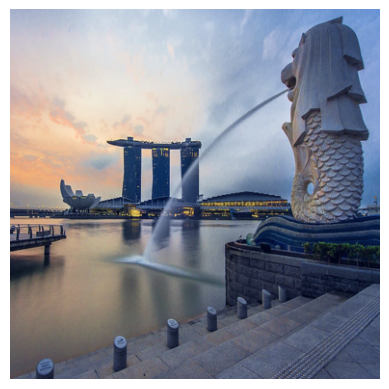

In [21]:
visualize(image_tensor=image)

# Nucleus Sampling vs. Beam Search: A Comparative Analysis

## Nucleus Sampling and Beam Search are two popular decoding strategies used in natural language processing, particularly in tasks like machine translation and image captioning. They both aim to generate the most likely sequence of words given an input (e.g., an image).

### Beam Search

    Principle: Beam search maintains a fixed-size list of candidate sequences (the beam). At each step, it extends all sequences in the beam by one word, keeping only the top-scoring candidates based on a language model.
    Process:
        Start with an empty sequence.
        Generate all possible next words and calculate their probabilities.
        Keep the top-k highest-scoring sequences (the beam).
        Repeat steps 2 and 3 until a desired sequence length is reached.
    Advantages: Efficient, often produces high-quality results.
    Disadvantages: Can be greedy, missing more diverse or creative sequences.

### Nucleus Sampling

    Principle: Nucleus sampling selects words based on their probabilities, but with a threshold. Only words with probabilities above a certain threshold (nucleus) are considered.
    Process:
        Generate all possible next words and calculate their probabilities.
        Keep only words with probabilities above the nucleus threshold.
        Sample a word from the remaining distribution.
        Repeat steps 2 and 3 until a desired sequence length is reached.
    Advantages: More diverse and creative outputs, can generate less common but still plausible sequences.
    Disadvantages: Can be less efficient than beam search, especially with large vocabularies.

## Key Differences:

    Determinism: Beam search is deterministic, always producing the same sequence given the same input and beam size. Nucleus sampling is stochastic, producing different sequences each time.
    Diversity: Nucleus sampling tends to generate more diverse and creative sequences compared to beam search.
    Efficiency: Beam search is generally more efficient than nucleus sampling, especially with large beam sizes.

## In the context of image captioning:

    Beam Search: Often used to generate concise and accurate captions. It's good for tasks where correctness and clarity are prioritized.
    Nucleus Sampling: Can be useful for generating more creative or diverse captions, especially when exploring different interpretations of the image.

## The choice between beam search and nucleus sampling often depends on the specific requirements of the task and the desired trade-off between efficiency, diversity, and accuracy.

In [22]:
def generate_caption():
    model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'    
    model = blip_decoder(
        pretrained=model_url, 
        image_size=image_size, 
        vit='base',
    )
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        # # beam search # returns error:
        # cap = model.generate(
        #     image, 
        #     sample=False, 
        #     # num_beams=3, # original implementation
        #     num_beams=1, # own implementation
        #     max_length=20, 
        #     min_length=5,
        # ) 

        # nucleus sampling
        cap = model.generate(
            image, 
            sample=True, 
            top_p=0.95, 
            max_length=20,
            min_length=5,
        ) 
    print(f"{len(cap)} caption(s) generated!")
    # print('caption: '+cap[0])
    return cap[0]    

In [23]:
caption = generate_caption()

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
1 caption(s) generated!


<class 'numpy.ndarray'> uint8 (384, 384, 3) 255 0


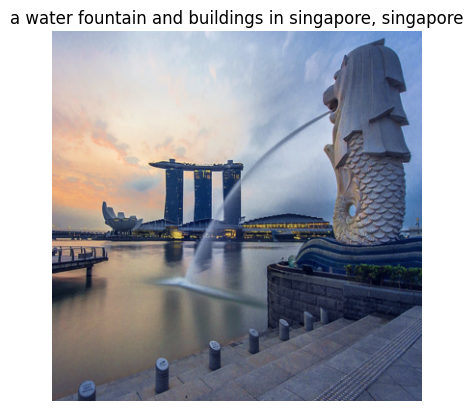

In [24]:
visualize(image_tensor=image, cap=caption)

In [25]:
# xx

# VQA
Perform visual question answering using finetuned BLIP model

In [26]:
# image_size = 480
# image = load_demo_image(
#     img_source=img_url,
#     image_size=image_size, 
#     device=device,
# )
# model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'    
# model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
# model.eval()
# model = model.to(device)
# question = 'where is the woman sitting?'
# with torch.no_grad():
#     answer = model(image, question, train=False, inference='generate') 
#     print('answer: '+answer[0])

# Feature Extraction

In [27]:
image_size = 224
image = load_demo_image(
    img_source=img_url,
    image_size=image_size, 
    device=device,
)
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'
model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)
caption = 'a woman sitting on the beach with a dog'
multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth


# Image-Text Matching

In [28]:
image_size = 384
image = load_demo_image(
    img_source=img_url,
    image_size=image_size, 
    device=device,
)
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'

model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
# model = model.to(device='cpu')
model = model.to(device=device)

caption = 'a woman sitting on the beach with a dog'
print(f'text: {caption}')

itm_output = model(image,caption,match_head='itm')

itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print(f'The image and text is matched with a probability of {itm_score}')

itc_score = model(image,caption,match_head='itc')
print(f'The image feature and text feature has a cosine similarity {itc_score}')

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: a woman sitting on the beach with a dog
The image and text is matched with a probability of tensor([0.0001], device='cuda:0', grad_fn=<SelectBackward0>)
The image feature and text feature has a cosine similarity tensor([[0.1351]], device='cuda:0', grad_fn=<MmBackward0>)
